In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

from design import BaseDesign
from film import TwoMaterialFilm
from spectrum import Spectrum
from optimizer.LM_gradient_descent import LM_optimize_d_simple
from optimizer.adam import AdamThicknessOptimizer
import copy
from utils.loss import calculate_RMS, calculate_RMS_f_spec
import pickle
import designer
from analyze_utils.structure import plot_layer_thickness
from analyze_utils.structure import diff_simple_film
from analyze_utils.result_io import save, load

import matplotlib.patches as mpatches


In [89]:

def make_random_film(N, pert_budget, seed=np.random.random()):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500)
    
    np.random.seed()
    d = np.random.random(N)
    d *= 3000 / np.sum(d)

    film = TwoMaterialFilm('SiO2', 'TiO2', 'Si', d_init=d)
    film.add_spec_param(inc_ang, wls)
    film_pert = copy.deepcopy(film)

    d = copy.deepcopy(d) # change reference of d to new
    pert = np.random.normal(loc=0.5, scale=pert_budget / d.shape[0], size=d.shape[0])
    d += pert
    film_pert.update_d(d)
    return film, film_pert

def make_pert(dim, budget, rep_num, optimizer, show=False):

    film, film_pert = make_random_film(dim, budget)

    # plot_layer_thickness(film)
    # plot_layer_thickness(film_pert)

    # print(f'before: loss={calculate_RMS(film, film_pert)}')
    adam_optimizer = AdamThicknessOptimizer(
        film_pert, 
        film.get_all_spec_list(), 
        1000, 
        1, 
        show=show,
        record=True,
    )
    record_films, losses = adam_optimizer()
    # print(f'after: loss={calculate_RMS(film, film_pert)}')
    sim = diff_simple_film(film_pert, film)
    return sim, losses




In [92]:

# layer_numbers = [2, 3, 5] + list(np.arange(10, 101, 10))
layer_numbers = np.arange(10, 100, 10)
budget = 100
rep = 50
# in total 30 * 50 rep * 1000 GD steps, or 1.5e6 gd steps, 1.5e4 s = 5 hours

In [93]:
# Exp
last_loss_rep, losses_rep, sims_rep  = [], [], []
for rep_id in range(rep):
    last_loss_rep.append([])
    sims_rep.append([])   
    losses_rep.append([]) 
    for N in layer_numbers:
        print(f'progress: adam, rep{rep_id}, {N} layers, max {layer_numbers[-1]}')
        cur_sim, cur_losses = make_pert(N, budget, optimizer='LM', rep_num=50, show=False)
        print(f'done, loss{cur_losses[-1]}, sim {cur_sim}')

        last_loss_rep[-1].append(min(cur_losses)) # shit... is best_losses_rep
        sims_rep[-1].append(cur_sim)
        losses_rep[-1].append(cur_losses)
        

save(f'./raw_result/result_dif_layers_l1budget_{budget}', last_loss_rep, sims_rep, losses_rep)


progress: adam, rep0, 10 layers, max 90
done, loss1.9648517578299466e-16, sim 0j
progress: adam, rep0, 20 layers, max 90
done, loss8.829651139429541e-13, sim (2.147468573336179e-12+0j)
progress: adam, rep0, 30 layers, max 90
done, loss0.0006143988302557566, sim (0.0030987881671326683+0j)
progress: adam, rep0, 40 layers, max 90
done, loss0.04967414547192313, sim (0.05822449653325249+0j)
progress: adam, rep0, 50 layers, max 90
done, loss0.023139662766528422, sim (0.027927353131947014+0j)
progress: adam, rep0, 60 layers, max 90
done, loss0.009701188682380978, sim (0.1714146852459404+0j)
progress: adam, rep0, 70 layers, max 90
done, loss0.02474996205873102, sim (0.32833084589974415+0j)
progress: adam, rep0, 80 layers, max 90
done, loss0.010377407524236078, sim (0.371492271915853+0j)
progress: adam, rep0, 90 layers, max 90
done, loss0.032997537357811246, sim (0.08043910036905785+0j)
progress: adam, rep1, 10 layers, max 90
done, loss8.50826822408615e-16, sim (4.926429634603362e-16+0j)
progre

0.0
film has no spec. use 1000 nm
film has no spec. use 1000 nm
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


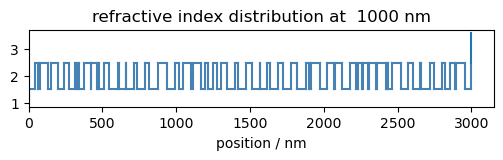

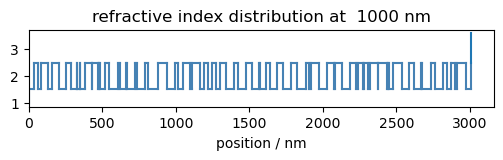

In [94]:
# see how much difference perturb itself introduces

origin_sim = []
origin_loss = []
origin_rep = 50
budget = 500
for rep in range(origin_rep): # 10 mins... why is this taking so long :(
    print(rep / origin_rep)
    cur_origin_sim = []
    cur_origin_loss = []
    for layer_number in layer_numbers:
        np.random.seed()
        film, film_pert = make_random_film(layer_number, budget / (1 + layer_number / 50))
        cur_origin_sim.append(diff_simple_film(film, film_pert))
        cur_origin_loss.append(calculate_RMS_f_spec(film_pert, film.get_all_spec_list()))

        if layer_number == layer_numbers[-1] and rep == 0:
            plot_layer_thickness(film)
            plot_layer_thickness(film_pert)
    origin_sim.append(cur_origin_sim)
    origin_loss.append(cur_origin_loss)


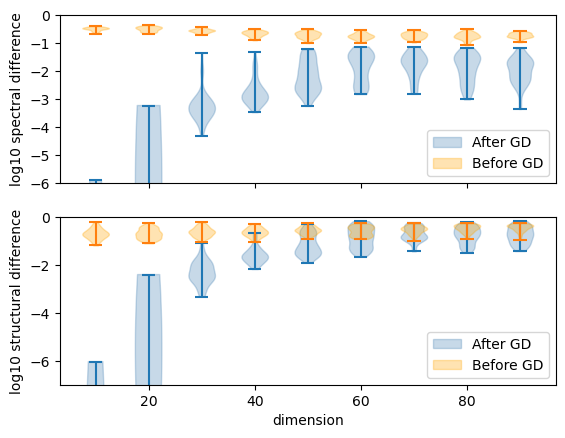

In [141]:
# new analysis

def plot_rep_violin(ax, x, arr, label, color):
    arr = np.array(arr)
    arr_ls = [np.log10(arr[:, i].real + 1e-50) for i in range(arr.shape[1])]
    s = ax.violinplot(
        arr_ls, 
        x, 
        widths=5, 
    )
    for pc in s['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
    return mpatches.Patch(
        color=s['bodies'][0].get_facecolor().flatten(), 
        label=label
    )

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
handle1 = plot_rep_violin(ax, layer_numbers, last_loss_rep, label='After GD', color='steelblue')
handle4 = plot_rep_violin(ax, layer_numbers, origin_loss, label='Before GD', color='orange')

handle2 = plot_rep_violin(ax2, layer_numbers, sims_rep, label='After GD', color='steelblue')
handle3 = plot_rep_violin(ax2, layer_numbers, origin_sim, label='Before GD', color='orange')
# ax2.plot([layer_numbers[0], layer_numbers[-1]], [-1, -1], ls='--', alpha=0.3, c='black', label='0.1 structural difference')
ax.legend(handles=[handle1, handle4], loc='lower right')
ax.set_ylim(-6, 0)
ax.set_ylabel('log10 spectral difference')

autohandles2, _ = ax2.get_legend_handles_labels()
ax2.legend(handles=autohandles2+[handle2, handle3], loc='lower right')
ax2.set_xlabel('dimension')
ax2.set_ylim(-7, 0)
ax2.set_ylabel('log10 structural difference')
fig.savefig('./localmin_res/diff_dim_10to100layers_log10.png', dpi=300)

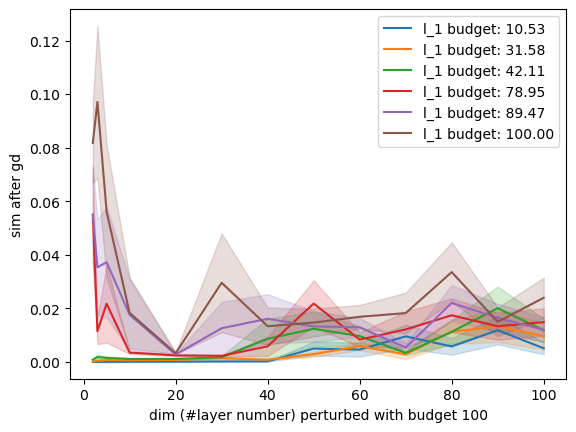

In [129]:
def plot_loss(loss, idx):
    fig, ax = plt.subplots(1, 1)
    j = -1
    for cur_loss, layer_number, i in zip(loss, layer_numbers, range(len(layer_numbers))):
        if i not in idx: 
            continue
        j += 1
        cur_std = np.std(cur_loss, axis=0) / 3
        cur_loss = np.mean(cur_loss, axis=0)
        ax.plot(budgets, cur_loss, label=f'{layer_number} layers', c=f'C{j}')
        ax.fill_between(budgets, cur_loss - cur_std, cur_loss + cur_std, color=f'C{j}', alpha=0.1)

    ax.set_xlabel('pert')
    ax.set_ylabel('loss after gd')
    ax.set_yscale('log')
    ax.set_ylim(1e-6, None)
    ax.legend()

def plot_sim(sim, idx):
    fig, ax = plt.subplots(1, 1)
    j = -1
    for cur_loss, layer_number, i in zip(sim, layer_numbers, range(len(layer_numbers))):
        if i not in idx: 
            continue
        j += 1
        cur_std = np.std(cur_loss, axis=0) / 3
        cur_loss = np.mean(cur_loss, axis=0)
        ax.plot(budgets, cur_loss, label=f'{layer_number} layers', c=f'C{j}')
        ax.fill_between(budgets, cur_loss - cur_std, cur_loss + cur_std, color=f'C{j}', alpha=0.1)

    ax.set_xlabel('pert')
    ax.set_ylabel('difference after gd')
    ax.set_yscale('log')
    ax.set_ylim(1e-6, None)
    ax.legend()

def plot_loss_st_some_pert_budget(loss, idx, plot_budgets):
    fig, ax = plt.subplots(1, 1)
    j = -1
    for k, budget in enumerate(budgets):
        if k not in plot_budgets:
            continue
        j += 1

        stds, losses = [], []
        plot_layers = []
        for cur_loss, layer_number, i in zip(loss, layer_numbers, range(len(layer_numbers))):
            if i not in idx: 
                continue
            stds.append(np.std(cur_loss, axis=0)[k] / 3)
            losses.append(np.mean(cur_loss, axis=0)[k])
            plot_layers.append(layer_number)
        losses, stds = np.array(losses), np.array(stds)
        ax.plot(plot_layers, losses, c=f'C{j}', label=f'l_1 budget: {budget:.2f}')
        ax.fill_between(plot_layers, losses - stds, losses + stds, color=f'C{j}', alpha=0.2)

    ax.set_xlabel('dim (#layer number) perturbed with budget 100')
    ax.set_ylabel('sim after gd')
    # ax.set_yscale('log')
    
    ax.legend()

# idx = [0, 3, 4, 5, 7]
# plot_loss(loss_adam, idx)
# plot_sim(sim_adam, idx)

idx = range(100)
plot_loss_st_some_pert_budget(loss_adam, idx, [2, 6, 8, 15, 17, 19])

# plot_loss(loss_LM)

In [ ]:
def perturb(budget):
    f = FilmSimple('SiO2', 'TiO2', 'SiO2', np.array([100., 100.] * 20))
    # f.add_spec_param(0., np.linspace(500, 1000, 500))
    f.add_spec_param(0., np.linspace(500, 1500, 500))

    from analyze_utils.plot_spectrum import plot_spectrum

    f_target = copy.deepcopy(f)

    pert = np.random.random(f.get_d().shape[0])
    f.update_d(f.get_d() + pert * budget / np.sum(np.abs(pert)))

    adam_optimize(f, f_target.get_all_spec_list(), 500, 1e-1, show=True)
    loss = calculate_RMS(f, f_target)
    similarity = diff_simple_film(f, f_target)
    return loss, similarity

# landscape at low dimension should be: more info, fewer local minima, but not this case in higher dimensions.
# well... seems to be the guilt of LM
# TODO: exp here at low dim (2, 3, 5 layers)
sim, similarity = [], []
budgets = [10, 20, 30, 40, 50, 55, 60, 65, 70, 80, 90, 100]
for _ in range(10):
    sim.append([])
    similarity.append([])
    for budget in budgets:
        l, s = perturb(budget)
        sim[-1].append(l)
        similarity[-1].append(s)


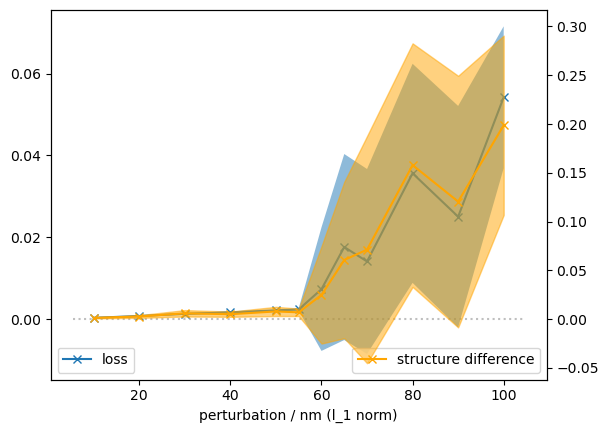

In [11]:
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.plot(budgets, np.mean(sim, axis=0), label='loss', marker='x', zorder=1)
ax.fill_between(budgets, np.mean(sim, axis=0) + np.std(sim, axis=0), np.mean(sim, axis=0) - np.std(sim, axis=0), alpha=0.5, zorder=10)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[-1]], [0, 0], c='grey', alpha=0.5, ls=':')
ax2.plot(budgets, np.mean(similarity, axis=0), label='structure difference', marker='x', c='orange')
ax2.fill_between(budgets, np.mean(similarity, axis=0) - np.std(similarity, axis=0), np.mean(similarity, axis=0) + np.std(similarity, axis=0), color='orange', alpha=0.5, zorder=11)
ax.legend()
ax2.legend(loc='lower right')
ax.legend(loc='lower left')
ax.set_xlabel('perturbation / nm (l_1 norm)')
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2) 
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])
align_yaxis(ax, ax2)